In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable


**Observation**: This Notebook is equivalent of running the following command.
```bash
pycbc_inference --verbose --config-files model.ini data.ini prior.ini sampler.ini --output-file inference-masses.hdf --seed 3214897 --nprocesses 2 --force
```

# PyCBC GW signal processing

In [1]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
import urllib.request

m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 'V1', 'L1']

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print(f"Processing {ifo} data")
    
    # Construct the URL and local filename
    url_template = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    formatted_url = url_template.format(ifo[0], ifo[0])
    filename = formatted_url.split('/')[-1]  # Extracts the filename from the URL
    
    # Download the file to the current directory
    urllib.request.urlretrieve(formatted_url, filename)
    fname = filename  # Use the local file path
    
    # Read and condition the data
    ts = read_frame(fname, f"{ifo}:LOSC-STRAIN",
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)
    ts = resample_to_delta_t(ts, 1.0/2048)
    ts = ts.time_slice(m.time - 112, m.time + 16)
    data[ifo] = ts.to_frequencyseries()

    # Estimate the PSD
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd

/usr/local/lib64/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Processing H1 data
Processing V1 data
Processing L1 data


In [2]:
psds

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x73348a7446d0>,
 'V1': <pycbc.types.frequencyseries.FrequencySeries at 0x73348a744820>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x73348a744880>}

# Chirp mass parameter estimation

In [17]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution
import numpy

static = {'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'inclination':2.4,
          'ra': 3.44615914,
          'dec': -0.40808407,
          'distance':40,
          'f_final':500,
         }

variable = ('mchirp',
            'q',
            'tc',
            )
prior = JointDistribution(variable, 
                Uniform(
                    mchirp=(1.197, 1.198),
                    q=(1, 1.0001),
                    tc=(m.time+.02, m.time+0.05),
                ),
        )

In [18]:
import copy
from pycbc.transforms import MchirpQToMass1Mass2

model = models.MarginalizedPhaseGaussianNoise(variable, data,
                                              low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25},
                                              high_frequency_cutoff = {'H1':500, 'L1':500, 'V1':500},
                                              psds = psds,
                                              static_params = static,
                                              prior = prior,
                                              waveform_transforms = [MchirpQToMass1Mass2()]
                                             )
smpl = sampler.EmceePTSampler(model, 2, 50, nprocesses=8)
_ = smpl.set_p0()

In [19]:
smpl.run_mcmc(50)

(2, 50, 50)
50


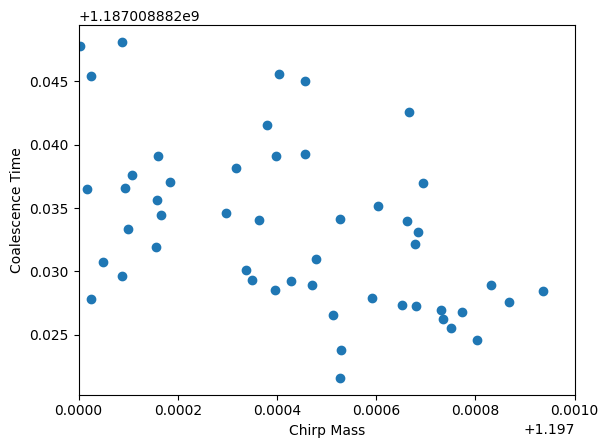

In [20]:

%matplotlib inline
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import Image
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(11)

s = smpl.samples
a = pylab.scatter(s['mchirp'][0,:,0],
                  s['tc'][0,:,0],
                 )
pylab.xlabel('Chirp Mass')
pylab.ylabel('Coalescence Time')
pylab.xlim(1.197, 1.198)
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['mchirp'][0,:,i], s['tc'][0,:,i]])
    a.set_offsets(dat.T)
    return (a, )


nsamples = len(s['tc'][0,0,:])
print(s['tc'].shape)
print(nsamples)
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

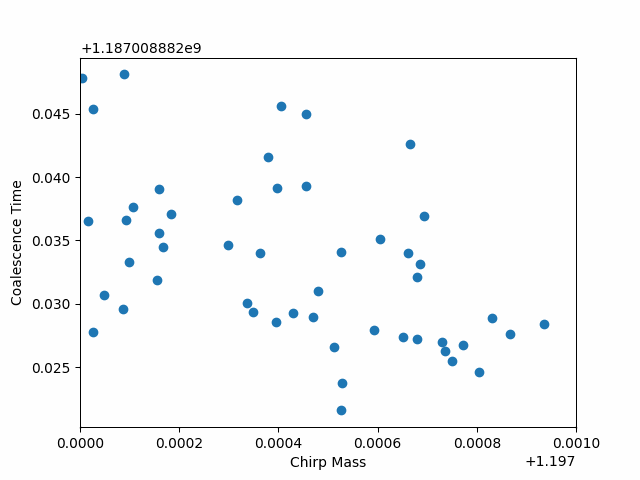

In [22]:
ani.save('move3.gif', writer=PillowWriter(fps=5))
with open('move3.gif','rb') as f:
    display(Image(data=f.read(), format='png'))